## Loading data

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
! cp -r /gdrive/'My Drive'/autoria/compressed.zip ./processed.zip
! cp -r /gdrive/'My Drive'/autoria/processed_table.csv ./processed_table.csv

In [0]:
import zipfile
file = zipfile.ZipFile('processed.zip')
file.extractall('processed')
file.close()

In [4]:
! ls

processed  processed_table.csv	processed.zip  sample_data


## Imports and preprocessing

In [0]:
import pandas as pd
import numpy as np
import os

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model
from keras.layers import Dropout, Dense, Input, Lambda
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

df = pd.read_csv('processed_table.csv')
df['label'] =  ( df['year'] - 2010 ) / 5#.apply(lambda x: np.log(x))
df['filename'] = df['ad_id'].apply(lambda x: str(x) + '.jpg')

In [124]:
df.describe()

,Unnamed: 0,ad_id,price,year,label
count,10628.000000,1.062800e+04,10628.000000,10628.000000,10628.000000
mean,5313.797422,2.223380e+07,19196.359428,2010.012890,0.002578
std,3068.545627,1.004364e+06,25326.937078,5.655317,1.131063
min,0.000000,3.034547e+06,600.000000,1963.000000,-9.400000
25%,2656.750000,2.227058e+07,7999.000000,2007.000000,-0.600000
50%,5313.500000,2.253555e+07,12285.000000,2011.000000,0.200000
75%,7971.250000,2.263110e+07,19720.500000,2014.000000,0.800000
max,10628.000000,2.267308e+07,463678.000000,2018.000000,1.600000


## Building and training the model

In [149]:
mobilenet = MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg')
for layer in mobilenet.layers:
	layer.trainable = False

new_input = Input(shape = (224, 224, 3))
x = Lambda(lambda y: (y/128)-1)(new_input)
x = mobilenet(x)
x = Dropout(rate=0.2)(x)
x = Dense(256, activation='tanh')(x)
x = Dropout(rate=0.2)(x)
x = Dense(1)(x)

model = Model(input=new_input, output=x)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               327936    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total para

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [150]:
reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, verbose=1)
stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

# generator = ImageDataGenerator(horizontal_flip=True, validation_split=0.1)

generator = ImageDataGenerator(rotation_range=10, zoom_range=0.1,
							   width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,
							   validation_split=0.1)#, featurewise_center = True, featurewise_std_normalization = True)

train_generator = generator.flow_from_dataframe(df, directory='processed/compressed', subset='training', y_col = 'label',
                                                class_mode='other', target_size = (224, 224), batch_size=128)
val_generator = generator.flow_from_dataframe(df, directory='processed/compressed', subset='validation', y_col = 'label',
                                              class_mode='other', target_size = (224, 224), batch_size=128)

Found 9566 images.
Found 1062 images.


In [152]:
model.compile(optimizer=Adam(lr=0.0001), loss='mse')
model.fit_generator(train_generator, steps_per_epoch=70, epochs=100,
					validation_data=val_generator, validation_steps=7, callbacks = [reduce, stop])


Epoch 1/100
70/70 [==============================] - 128s 2s/step - loss: 1.0805 - val_loss: 1.2485
Epoch 2/100
70/70 [==============================] - 104s 1s/step - loss: 1.0177 - val_loss: 1.1255
Epoch 3/100
70/70 [==============================] - 106s 2s/step - loss: 1.0511 - val_loss: 1.1607

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/100
70/70 [==============================] - 94s 1s/step - loss: 1.0080 - val_loss: 1.1766
Epoch 5/100
70/70 [==============================] - 106s 2s/step - loss: 0.9900 - val_loss: 1.0827
Epoch 6/100
70/70 [==============================] - 104s 1s/step - loss: 0.9935 - val_loss: 1.2127

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 7/100
70/70 [==============================] - 102s 1s/step - loss: 1.0014 - val_loss: 1.0866

Epoch 00007: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
Epoch 8/100
 7/70 [==>...........................] - ETA:

KeyboardInterrupt: ignored

## Results and some other stuff

In [153]:
model.get_weights()[-2].max(), model.get_weights()[-2].min()

(0.12941112, -0.13045177)

In [0]:
batch_x, batch_y = val_generator.next()
batch_predicted = model.predict(batch_x)

In [158]:
(np.hstack((batch_y.reshape(-1, 1), batch_predicted))* 5 + 2010).astype('int')

array([[2010, 2009],
       [2013, 2010],
       [2002, 2009],
       [2006, 2010],
       [2005, 2012],
       [2007, 2007],
       [2014, 2010],
       [2007, 2007],
       [2014, 2013],
       [2011, 2011],
       [2002, 2010],
       [2005, 2009],
       [2011, 2012],
       [2014, 2011],
       [2011, 2009],
       [1993, 2010],
       [2005, 2007],
       [1995, 2007],
       [2018, 2014],
       [2013, 2010],
       [2005, 2008],
       [2009, 2010],
       [2012, 2011],
       [2018, 2009],
       [2015, 2011],
       [1997, 2007],
       [2018, 2013],
       [2009, 2010],
       [2013, 2010],
       [2011, 2013],
       [2012, 2011],
       [1996, 2007],
       [2000, 2007],
       [2010, 2010],
       [1984, 2007],
       [2008, 2014],
       [2016, 2011],
       [2014, 2011],
       [2007, 2011],
       [2008, 2007],
       [2012, 2012],
       [2013, 2008],
       [2011, 2009],
       [2015, 2010],
       [2009, 2008],
       [2006, 2011],
       [2010, 2009],
       [2015,

In [156]:
from scipy.stats.stats import pearsonr
pearsonr(batch_y.reshape(-1, 1), batch_predicted)[0]

array([0.54245769])

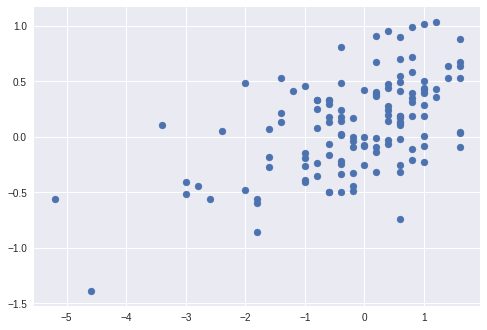

In [157]:
from matplotlib import pyplot as plt
plt.scatter(batch_y.reshape(-1, 1), batch_predicted)

[[-0.6591724]] [[2006.7041]]
      Unnamed: 0     ad_id  price  year  label      filename
7072        7072  22610299  35900  2012    0.4  22610299.jpg


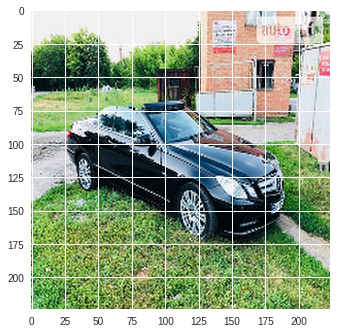

In [159]:
test_id = 22610299
tmp_image = imread('processed/compressed/{}.jpg'.format(test_id))
prediction = model.predict(tmp_image.reshape(1, 224, 224, 3))
print(prediction, prediction * 5 + 2010)
print( df[df['ad_id'] == test_id] )
plt.imshow(tmp_image, interpolation = 'lanczos')